## QPP = Qiskit-Pennylane-Pytorch

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import pennylane as qml

import torch
from torch.utils.data import DataLoader
from torch.nn import Module, Linear, Softmax
from torchvision import datasets, transforms
from torch import cat, no_grad, manual_seed
from torch import optim
from torch.nn import NLLLoss
from torch.autograd import Variable

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

## Dataset

In [5]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 16
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.CenterCrop((20,20)),
                                                                            transforms.Resize((8,8)),
                                                                            transforms.Normalize((0.1307,), (0.3081,))])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

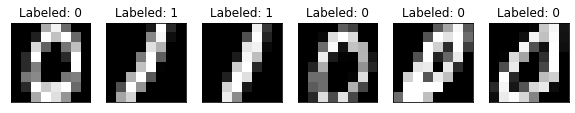

In [6]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [7]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),
                                                                             transforms.CenterCrop((20,20)),
                                                                             transforms.Resize((8,8)),
                                                                             transforms.Normalize((0.1307,), (0.3081,))])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

## Defining QNode

In [23]:
class QConv2D(qml.qnn.TorchLayer):
    def __init__(self, kernel_size=(3,3), strides=(2,2), n_qubits = 1, n_layers = 1):
        
        n_inputs = np.prod(kernel_size)
        self.kernel_size = kernel_size
        self.strides = strides
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.all_qubits = [i for i in range(n_qubits)]
        
        self.theta = [Parameter(f'θ{i}') for i in range(n_layers*n_qubits)]
        self.theta = np.asarray(self.theta).reshape((n_layers, n_qubits))
        
        self.circuit = self.create_circuit()
        self.qml_circuit = qml.load(self.circuit, format='qiskit')
        
        # randomly initialize parameters from a normal distribution
        w = np.random.normal(0, np.pi, (n_layers, n_qubits, n_inputs))
        w = Variable(torch.tensor(w), requires_grad=True)
        b = Variable(torch.randn(1), requires_grad=True)
        
        self.weight_shapes = {
            'w': (n_layers, n_qubits, n_inputs),
            'b': (1,)
        }
        
        self.dev = qml.device('qiskit.aer', 
                              wires=n_qubits)
        if torch.cuda.is_available():
            self.dev.backend.set_options(device='GPU')
            
        self.qnode = self.build()
        
        super(QConv2D, self).__init__(self.qnode, self.weight_shapes)
    
    def create_circuit(self):
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(self.all_qubits)
        
        for l in range(self.n_layers):
            for q in self.all_qubits:
                circuit.ry(self.theta[l][q], q)
            if (l & 1):
                for q0, q1 in zip(self.all_qubits[1::2], self.all_qubits[2::2] + [self.all_qubits[0]]):
                    circuit.cz(q0,q1)
            else:
                for q0, q1 in zip(self.all_qubits[0::2], self.all_qubits[1::2]):                 
                    circuit.cz(q0,q1)
        return circuit
    
    def build(self): 
        @qml.qnode(self.dev)
        def qnode(inputs,w,b):
            params = {}
            for l in range(self.n_layers):
                for q in self.all_qubits:
                    params[self.theta[l][q]] = (np.pi/2)*torch.tanh(torch.dot(w[l, q], inputs) + b).item()
            self.qml_circuit(params = params )
            Z = qml.expval(qml.PauliZ(wires=self.n_qubits-1))
            return Z
        return qnode
    
    def forward(self, inputs):
        
        k = self.kernel_size
        s = self.strides
        
        iter_x = int((inputs.shape[2] - k[0]) / s[0] + 1)
        iter_y = int((inputs.shape[3] - k[1]) / s[1] + 1)
        
        out = []
        for i in range(iter_x):
            for j in range(iter_y):
                _x = inputs[:,0, i*s[0]:i*s[0] + k[0], j*s[1]:j*s[1] + k[1]]
                _x = _x.flatten(start_dim = 1)
                out+= [torch.stack([self._evaluate_qnode(e) for e in torch.unbind(_x)]).reshape(-1,1)]
        out = torch.cat(out,-1)
        out = torch.reshape(out,(-1,1, iter_x,iter_y))
        return torch.tanh(out)

In [24]:
class HybridModel(Module):
    def __init__(self):
        super().__init__()
        self.qlayer_1 = QConv2D(n_qubits = 1, n_layers = 1)
        self.clayer_1 = Linear(9,2)
        self.softmax = Softmax(dim=1)

    def forward(self, x):
        x = self.qlayer_1(x)
        x = x.flatten(start_dim = 1)
        x = self.clayer_1(x)
        return self.softmax(x)
    
model = HybridModel()

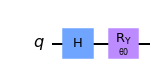

In [25]:
model.qlayer_1.circuit.draw('mpl')

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_func = NLLLoss()

# Start training
epochs = 1  # Set number of epochs
history = []  # Store history
model.train()  # Set model to training mode

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        acc = accuracy(output, target)
        loss = loss_func(output, target)  # Calculate loss
        history.append({'loss':loss.item(), 'acc':acc}) # Store training loss and acc
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights 
        print(history[-1])
    print("Training [{:.0f}%]\tLoss: {}".format(100.0 * (epoch + 1) / epochs, history[-1]))

{'loss': -0.3358628749847412, 'acc': tensor(0.0625)}
{'loss': -0.4649423360824585, 'acc': tensor(0.4375)}
{'loss': -0.4040420651435852, 'acc': tensor(0.2500)}
{'loss': -0.6185375452041626, 'acc': tensor(0.6250)}
{'loss': -0.6871762871742249, 'acc': tensor(0.9375)}
{'loss': -0.7803006768226624, 'acc': tensor(1.)}
{'loss': -0.8343037366867065, 'acc': tensor(1.)}
{'loss': -0.8931998014450073, 'acc': tensor(1.)}
{'loss': -0.8526043891906738, 'acc': tensor(0.9375)}
{'loss': -0.9164679646492004, 'acc': tensor(1.)}
{'loss': -0.9369229674339294, 'acc': tensor(1.)}
{'loss': -0.9097005128860474, 'acc': tensor(0.9375)}
{'loss': -0.8333969116210938, 'acc': tensor(0.8750)}
Training [100%]	Loss: {'loss': -0.8333969116210938, 'acc': tensor(0.8750)}


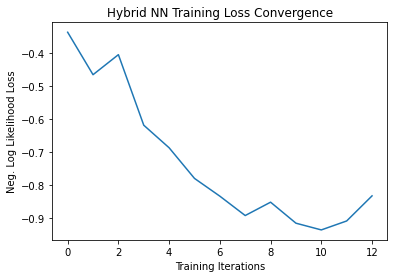

In [28]:
# Plot loss convergence
loss_list = [x['loss'] for x in history]
plt.plot(loss_list)
plt.title("Hybrid NN Training Loss Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

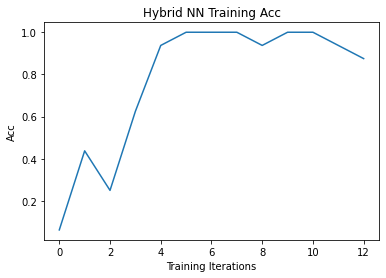

In [29]:
acc_list = [x['acc'] for x in history]
plt.plot(acc_list)
plt.title("Hybrid NN Training Acc")
plt.xlabel("Training Iterations")
plt.ylabel("Acc")
plt.show()

In [32]:
model.eval()  # set model to evaluation mode
with no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        _, preds = torch.max(output, dim=1)
        correct += torch.sum(preds == target).item()
    print(
        "Performance on test data:\n\tAccuracy: {:.1f}%".format(
            correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Accuracy: 87.5%


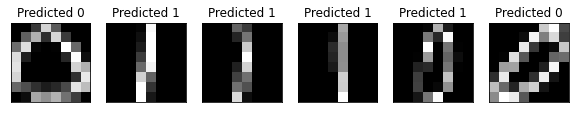

In [35]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1